# How a radar determines range
## Section 1: How a radar determines range  
A radar determines the range (distance) to an object by sending out a pulse of energy and then waits (listens) until the pulse is reflected off the object and returns to the radar.   Our signal model for the transmitted signal is:

$$x_{tx}(t) = \text{rect}\left(\frac{t}{T}\right)\cos(2\pi f t) $$  

The received signal will reflect off a scatterer at a distance $R$ away from the radar and be received at a time $t_{rx}$ later:

$$x_{rx}(t) = \text{rect}\left(\frac{t-t_{rx}}{T}\right)\cos(2\pi f (t - t_{rx})) $$  

Since the the signal is a wave propogating in free space we can determine the disctance to the point from the time it takes to come back to the receiver as:
$$R = \frac{ct_{rx}}{2}$$  
Where $c$ is the speed of light.  The reason for the division by two is because the time delay we measure is the time it takes for the wave to travel to the target, reflect off the scatterer, and come back to the radar.  Because of this the time delay we measure really corresponds to $2R$, hence the divide by two.  

The processing of the signal can determine the distance to an object by using a detector to detect when the signal returned in the receive window

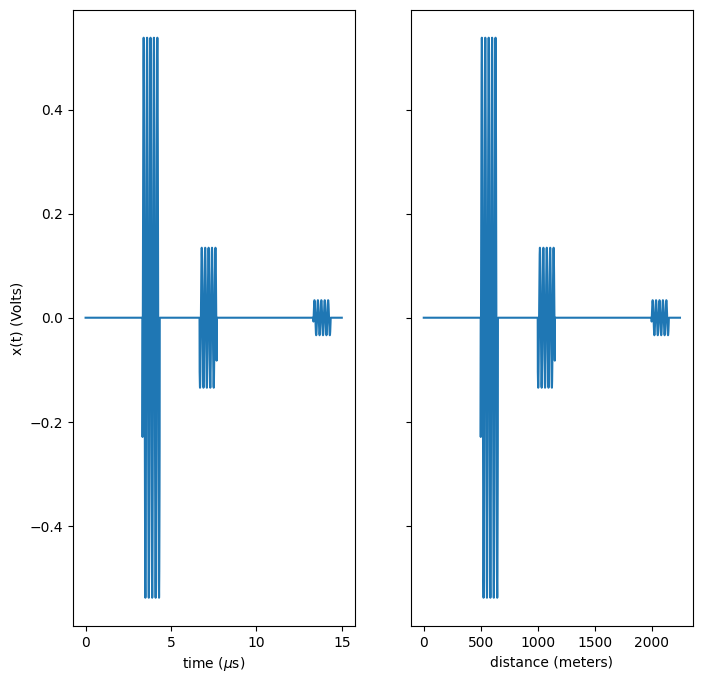

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light

fs = 1e9
t_max = 15e-6
P_t = 10e3
G = 1e3
rcs = 1
freq = 5e6
pulse_duration = 1e-6
t = np.arange(0, t_max, 1/fs)

def returned_signal(distance, t, T=pulse_duration, f=freq):
    time_delay = 2 * distance / speed_of_light
    returned_signal = np.zeros_like(t, dtype=float)
    
    # Determine the times within the chirp duration
    mask = (t >= time_delay) & (t <= time_delay + T)
    # t_within = t[mask] - time_delay  # Time relative to the chirp start
    t_within = t[mask]# Time relative to the chirp start
    
    # Set the chirp signal for the valid times
    wavelen = speed_of_light / f
    amplitude = np.sqrt((P_t * G**2 * wavelen**2 * rcs)/((4*np.pi)**3 * distance**4))
    returned_signal[mask] = amplitude * np.cos(2*np.pi*f*(t_within))
    return returned_signal

z = returned_signal(500, t) + returned_signal(1000, t) + returned_signal(2000, t)
d = t * speed_of_light / 2

fig, axs = plt.subplots(ncols=2, figsize=(8, 8), sharey=True)
axs = axs.ravel()
axs[0].plot(t / 1e-6, z)
axs[0].set_xlabel('time (' + '$\mu$' + 's)')
axs[0].set_ylabel('x(t) (Volts)')
axs[1].plot(d, z)
axs[1].set_xlabel('distance (meters)')
plt.show()


Here we can see that the returned signal is quite weak.  One term we neglected is noise.  Our system will be noisy, so we can rewrite our received signal model as:
$$x_{rx}(t) = \text{rect}\left(\frac{t-t_{rx}}{T}\right)\cos(2\pi f (t - t_{rx})) + n(t) $$  
Where $n(t)$ is our system noise.  This is typically modelled as additive white guassian noise which means $n(t) \approx \mathcal{N}(0, \sigma_n)$ where $\sigma_n$ is the avg noise variance of our system.  

Let's see what the received signal looks like in the presence of noise: 

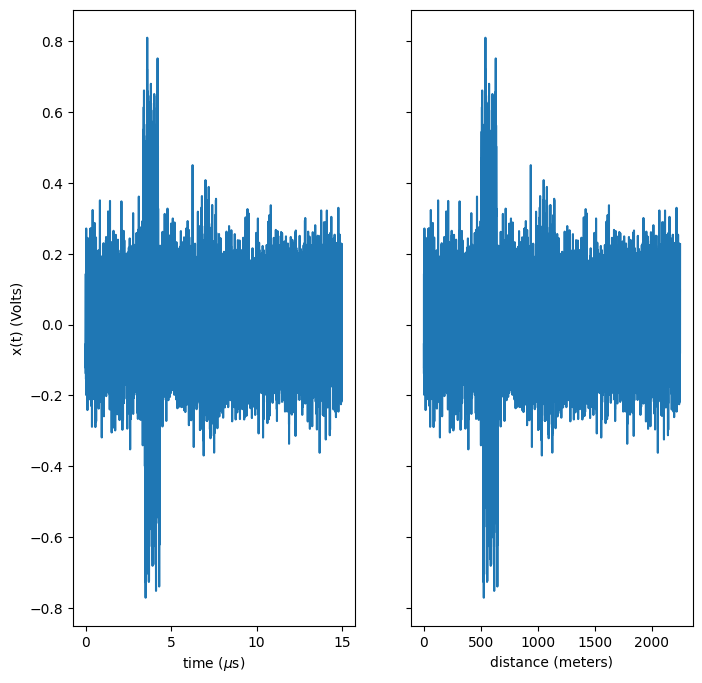

In [12]:
noise = np.random.normal(0, 0.1, len(t))
z = returned_signal(500, t) + returned_signal(1000, t) + returned_signal(2000, t) + noise
fig, axs = plt.subplots(ncols=2, figsize=(8, 8), sharey=True)
axs = axs.ravel()
axs[0].plot(t / 1e-6, z)
axs[0].set_xlabel('time (' + '$\mu$' + 's)')
axs[0].set_ylabel('x(t) (Volts)')
axs[1].plot(d, z)
axs[1].set_xlabel('distance (meters)')
plt.show()

**TODO: Talk about max unambiguous range**
## Matched filtering  
The solution to determining the location of our signal in the presence of noise is to use matched filtering.  Matched filtering is an optimal filter in the presence of gaussian noise.  The matched filter is defined as the conjugate time reversed version of our original signal i.e)
$$h(t) = x^*(-t)$$  

To find the output of the matched filter process we convolve the matched filter with our input signal:

$$y(t) = $$  

There are a few ways to think about matched filtering:
1. Cross correlating your received signal with the signal you transmitted
2. Template matching 

For the example above lets see what the ouput looks like after matched filtering


(15000,)

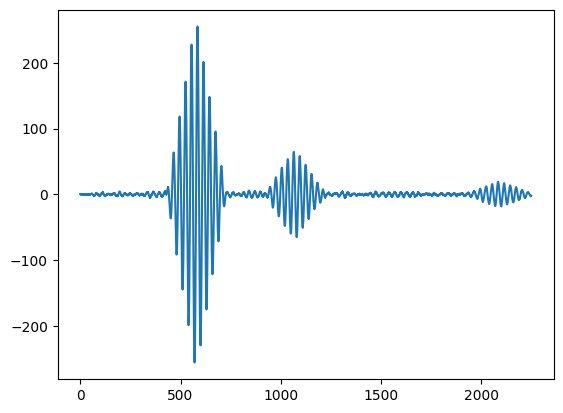

In [15]:
z = returned_signal(500, t) + returned_signal(1000, t) + returned_signal(2000, t) + noise
mask = (t >= 0) & (t <= pulse_duration)
t_within = t[mask]
h = np.cos(2*np.pi*freq*(t_within))
matched_filter_output = np.convolve(z, np.flip(np.conj(h)), mode='same')
plt.figure()
plt.plot(d, matched_filter_output)
matched_filter_output.shape


## The problem with using sine waves

We can see now that our signal is impossible to detect and we cant determine the distance to objects anymore!  We can see that there are two fundamental problems with determining range using sine waves:
1. Difficult to distinguish in the presence of noise
2. Resolution of a pulsed sine wave is $\rho = \frac{1}{2}cT$.
    - If we want fine resolution we need short pulse durations
    - The shorter our pulse duration the less feasible it is for the system to transmit the same amount of power

## Linear frequency modulation
Rather than using a short rectangular pulse with a duration $T_{rect} = \frac{1}{B}$, we instead spread the signal’s frequency content over a longer duration $T$. One way of achieving this is *linear frequency modulation* (LFM), where the frequency of the pulse increases or decreases linearly over time. This is also know as a chirp waveform.

Mathematically, the real portion a chirped signal can be represented as:
$$s(t) = A e^{j\left(2\pi f_0 t + \pi \gamma t^2 \right)}$$
where:  
* $f_0$ is the initial frequency,
* $B$ is the bandwidth
* $\gamma = \frac{B}{T}$ is the chirp rate

This process has left us with a longer duration pulse that retains the bandwidth of the short rect. One helpful way of thinking of this process is that we have applied a linearly increasing phase delay to each frequency component of the short duration pulse we wanted. In order to recover a short duration pulse from our chirp signal, all we need to do is apply the opposite delay to the signal. This can be done via matched filtering.




## Matched filtering
Idk feel free to break it up but I want to talk about matched filtering and stuff here and pulse compression stuff

- Define matched filter
    - Filter dat be maximizing that SNR tho
- Introduce LFM and some plots around it
- Derive matched filter output for transmitting baseband LFM and receiving it at time later $t_d$ aka $e^{\pi \gamma (t - t_d)^2}$
    - Basically want to show how the output ends up being sinc function with peak correspoding to time delay $t_d$
## Section 4: Stretch processing
- Show how we matched filter directly with hardware

## Section 5: Stepped frequency waveforms
- Talk about ye ol step chirp waveforms
